## Get Yelp data (reviews, users, businesses), check out available locations on the map and decide to focus on operating restaurants in Largo, FL

### Loading data

In [ ]:
#https://github.com/Kaggle/kagglehub/issues/214
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/yelp-dataset


In [ ]:
import json
import pandas as pd
data_file = open(path + "/yelp_academic_dataset_business.json")
data = []
for line in data_file:
  data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
data_file = open(path + "/yelp_academic_dataset_user.json")
data = []
for line in data_file:
  data.append(json.loads(line))
user_df = pd.DataFrame(data)
data_file.close()

In [ ]:
data_file = open(path + "/yelp_academic_dataset_review.json")
data = []
for line in data_file:
  data.append(json.loads(line))
review_df = pd.DataFrame(data)
data_file.close()

### Visualize locations of businesses in the dataset

In [ ]:
# prompt: put the unique cities on a map to visualize

import pandas as pd
import folium

# Get the unique cities and their coordinates (using the first occurrence)
unique_cities = business_df[['city', 'latitude', 'longitude']].drop_duplicates(subset=['city'])

# Create a map centered around the approximate center of the dataset's locations
# You might want to adjust the starting location based on your data
map_osm = folium.Map(location=[unique_cities['latitude'].mean(), unique_cities['longitude'].mean()], zoom_start=5)

# Add markers for each unique city
for index, row in unique_cities.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.Marker([row['latitude'], row['longitude']], popup=row['city']).add_to(map_osm)

# Display the map
map_osm

### Decide to focus on currently operating restaurants in Largo, FL

In [ ]:
#First let's narrow down to Florida
business_df.loc[business_df['state'] == 'FL', 'city'].value_counts().head(20)

city
Tampa               9048
Clearwater          2221
Saint Petersburg    1663
St. Petersburg      1185
Brandon             1033
Largo               1002
Palm Harbor          665
New Port Richey      604
Lutz                 591
Riverview            588
Wesley Chapel        560
Pinellas Park        512
Dunedin              490
Spring Hill          400
Tarpon Springs       398
St Petersburg        387
Seminole             359
Oldsmar              286
Valrico              276
Port Richey          270
Name: count, dtype: int64

In [ ]:
#many ways to spell Largo
business_df.loc[(business_df['state'] == 'FL') & (business_df['city'].str.lower().str.contains('largo')), 'city'].value_counts().head(20)

city
Largo                 1002
LARGO                    3
​Largo                   1
largo                    1
Largo (Walsingham)       1
Key Largo                1
Name: count, dtype: int64

In [ ]:
#get rid of Key Largo
business_df.loc[(business_df['state'] == 'FL') & (business_df['city'].str.lower().str.contains('largo')) & ~(business_df['city'].str.lower().str.contains('key')), 'city'].value_counts().head(20)

city
Largo                 1002
LARGO                    3
​Largo                   1
largo                    1
Largo (Walsingham)       1
Name: count, dtype: int64

In [ ]:
#let's focus on those businesses that are open currently!
focus = business_df.loc[(business_df['state'] == 'FL') & (business_df['city'].str.lower().str.contains('largo')) & ~(business_df['city'].str.lower().str.contains('key')) & (business_df['is_open']),
 ['business_id', 'name', 'categories', 'stars', 'review_count']].set_index('business_id')

In [ ]:
#at least we have 5 reviews for each, which will suffice
focus.sort_values(by='review_count', ascending=True).head(2)

name  \
business_id                                                  
FfDBLOtjEYjQpjvt5rwx4A  Largo Central Park Nature Preserve   
z3Zv5di2BEok__snpopeBA                   Largo Golf Course   

                                                               categories  \
business_id                                                                 
FfDBLOtjEYjQpjvt5rwx4A  Active Life, Tours, Hiking, Parks, Hotels & Tr...   
z3Zv5di2BEok__snpopeBA  Active Life, Golf, Fish & Chips, Golf Equipmen...   

                        stars  review_count  
business_id                                  
FfDBLOtjEYjQpjvt5rwx4A    4.5             5  
z3Zv5di2BEok__snpopeBA    4.0             5

In [ ]:
#create a new row for each category the business operates in
dups = focus.categories.str.split(',').explode()

In [ ]:
#drop missing categories
to_drop = dups.isna().sum()
dups = dups.dropna()
print(f'Dropping {to_drop} missing values')

Dropping 2 missing values


In [ ]:
dups.value_counts().head(10)

categories
 Restaurants         153
 Shopping            116
 Home Services       100
 Food                 90
 Health & Medical     88
 Local Services       67
 Automotive           64
 Beauty & Spas        59
Restaurants           55
 Active Life          41
Name: count, dtype: int64

In [ ]:
#focusing on restaurants
restaurants = dups[dups.str.lower().str.contains('restaurant')]

In [ ]:
#creating rest that has the business information about restaurants in our focus area
rest = focus.loc[restaurants.index]

In [ ]:
#drop dulicates which can arise if 'restaurant' was mentioned multiple times under categories
rest = rest.drop_duplicates()

In [ ]:
#get the relevant reviews for the chosen businesses (Largo Florida, currently operating restaurant businesses)
df = review_df[review_df.business_id.isin(rest.index)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df.to_csv('/content/drive/MyDrive/personal stuff/Social media/YelpReviewLargoRestaurants.csv')

### Sanity check - from reviews dataset, we should arrive to same stars and number of ratings

In [ ]:
check = review_df[review_df.business_id.isin(rest.index)].groupby('business_id').aggregate({'stars': 'mean', 'review_id': 'count'})

In [ ]:
check.columns = ['stars', 'review_count']

In [ ]:
merged_check = rest.merge(check, on='business_id', suffixes=('_business', '_review'))

In [ ]:
merged_check.head(5)

name  \
business_id                                        
aNtKyc2rr-uK5cqzY9TVQQ    Chipotle Mexican Grill   
gl9APAes1BYYt_8UsDVsPg        Ted's Luncheonette   
1lC4dy6jlB2tBdBWbocO7Q                   Wendy's   
k3EQAQGptzHzl6oEoas61w  Ithai & Sushi Restaurant   
q61niB21oQPmZlO3wsSO7Q                    Arby's   

                                                categories  stars_business  \
business_id                                                                  
aNtKyc2rr-uK5cqzY9TVQQ     Mexican, Fast Food, Restaurants             3.0   
gl9APAes1BYYt_8UsDVsPg     Breakfast & Brunch, Restaurants             4.0   
1lC4dy6jlB2tBdBWbocO7Q     Restaurants, Fast Food, Burgers             2.0   
k3EQAQGptzHzl6oEoas61w       Restaurants, Thai, Sushi Bars             4.0   
q61niB21oQPmZlO3wsSO7Q  Fast Food, Restaurants, Sandwiches             2.0   

                        review_count_business  stars_review  \
business_id                                                   
aNtKyc2rr-uK5cqzY9TVQQ                     19      3.200000   
gl9APAes1BYYt_8UsDVsPg                     37      3.972973   
1lC4dy6jlB2tBdBWbocO7Q                     22      1.791667   
k3EQAQGptzHzl6oEoas61w                     63      4.191176   
q61niB21oQPmZlO3wsSO7Q                     14      1.785714   

                        review_count_review  
business_id                                  
aNtKyc2rr-uK5cqzY9TVQQ                   20  
gl9APAes1BYYt_8UsDVsPg                   37  
1lC4dy6jlB2tBdBWbocO7Q                   24  
k3EQAQGptzHzl6oEoas61w                   68  
q61niB21oQPmZlO3wsSO7Q                   14

In [ ]:
#we can see that the stars seem to be rounded to the nearest half integer and the review counts have some differences - maximum discrepancy in review counts is 20%
import numpy as np
(np.abs(merged_check['review_count_review']-merged_check['review_count_business'])/merged_check['review_count_business'] * 100).sort_values(ascending=False)

business_id
w9P_hkzR_AomykakSFFQyA    20.000000
ehWn19msSrigN7-57FyFOQ    16.000000
LctFXe5Sg6_Ao_OzYXod0Q    15.384615
_W68O1txBhPTngnM0xqw9A    14.925373
EnbfvuKmmVIj4poxMf9hYQ    14.893617
                            ...    
tcJe4J121rEwR2AiG9fSKw     0.000000
egL9ZGqhQUD80pfo3MCDYQ     0.000000
_g8sUJqELybsK9yfuxSdig     0.000000
SswfM2l0WH0cStMvlLWFYg     0.000000
s7JeIypuSaeHIQNZ4rSX0w     0.000000
Length: 208, dtype: float64

In [ ]:
merged_check.loc['w9P_hkzR_AomykakSFFQyA']

name                                                                Publix
categories               Shopping, Bakeries, Drugstores, Restaurants, B...
stars_business                                                         2.5
review_count_business                                                   10
stars_review                                                      2.416667
review_count_review                                                     12
Name: w9P_hkzR_AomykakSFFQyA, dtype: object

There is not much we can do about this discrepancy, we might as well just rely on the reviews dataset from now onwards and treat that as ground truth.

## Descriptive Analysis (reviews, users, businesses)

### Reviews

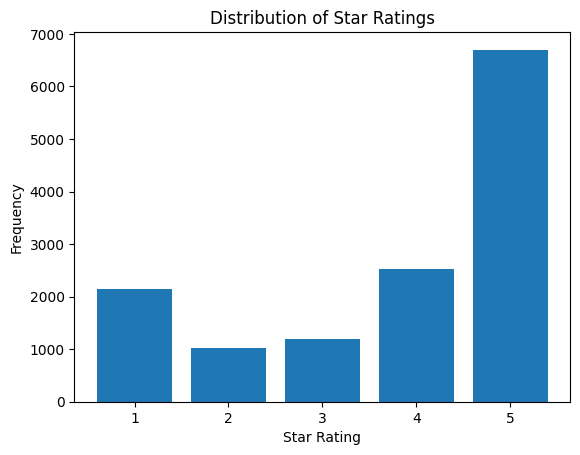

In [ ]:
# prompt: make histogram of df['stars'] - only xticks should be 1,2,3,4,5

import matplotlib.pyplot as plt

plt.hist(df['stars'], bins=[1, 2, 3, 4, 5, 6], align='left', rwidth=0.8)
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings')
plt.show()

In [ ]:
df['stars'].describe()

count    13575.000000
mean         3.781510
std          1.501975
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars, dtype: float64

In [ ]:
pd.concat([df['stars'].value_counts(), df['stars'].value_counts(normalize=True) * 100],axis=1).rename(columns={0:'count', 'proportion':'proportion (%)'})

count  proportion (%)
stars                       
5.0     6700       49.355433
4.0     2520       18.563536
1.0     2141       15.771639
3.0     1185        8.729282
2.0     1029        7.580110

Most people gave 5 stars, followed by 4 stars and then 1 star

In [ ]:
# prompt: make histogram for number of words per review

import matplotlib.pyplot as plt
# Calculate the number of words in each review
df.loc[:, 'word_count'] = df['text'].apply(lambda x: len(x.split()))

In [ ]:
df['word_count'].describe()

count    13575.000000
mean        83.427698
std         77.486623
min          3.000000
25%         34.000000
50%         58.000000
75%        105.000000
max        905.000000
Name: word_count, dtype: float64

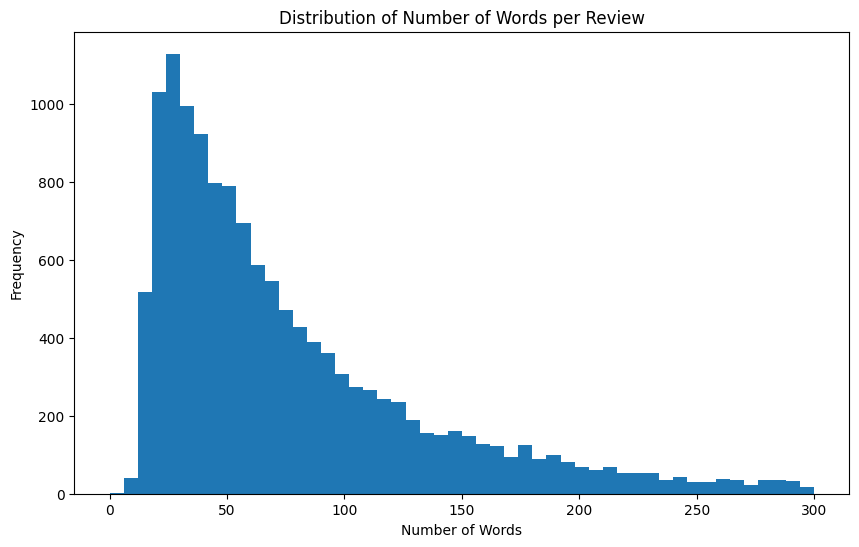

In [ ]:
# Plot a histogram of the word counts
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, range=(0, 300)) # Adjust bin and range as needed
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words per Review')
plt.show()

distribution shows long tail (we cut it off after 300 words but maximum is 905), mean is 83.42

In [ ]:
#data is collected from July 19th, 2025
df.date.min()

'2005-07-19 19:08:50'

In [ ]:
#last review is from 19st January 2022
df.date.max()

'2022-01-19 19:22:59'

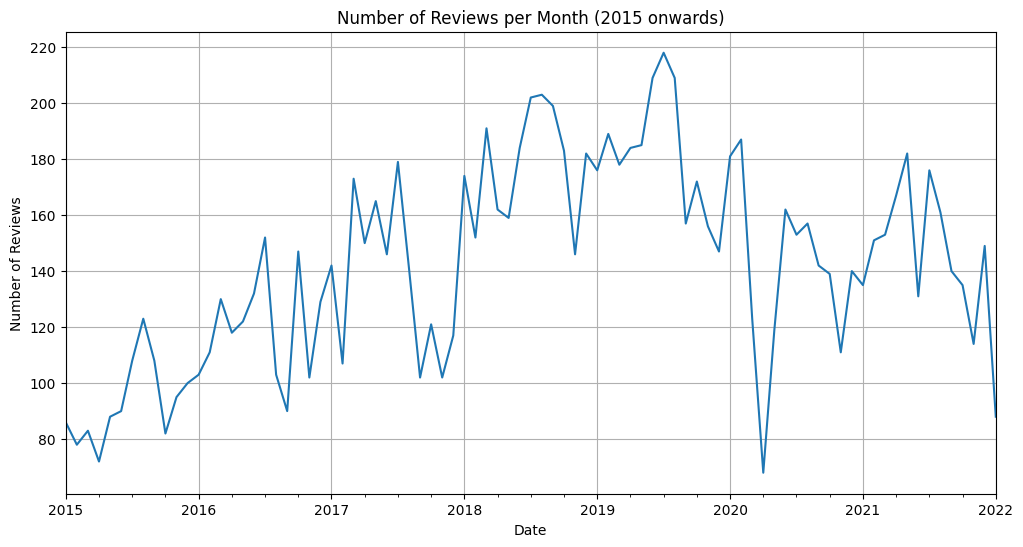

In [ ]:
# prompt: make a line plot of the total number of reviews per month over the course of the dataset date field - start from 2015

import pandas as pd
import matplotlib.pyplot as plt
# Convert the 'date' column to datetime objects
df.loc[:, 'date'] = pd.to_datetime(df['date'])

# Filter data to start from 2015
df_filtered = df[df['date'].dt.year >= 2015].copy()

# Group by month and count reviews
monthly_reviews = df_filtered.set_index('date').resample('M')['review_id'].count()

# Plot the average number of reviews per month
plt.figure(figsize=(12, 6))
monthly_reviews.plot(kind='line')
plt.title('Number of Reviews per Month (2015 onwards)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

Generally there's an upward trend on Largo, FL restaurant reviews on Yelp until COVID; there's a big drop when most people became aware/scared of COVID (2020 March) and review writing has not fully recovered since then


Note: 2022 January is not really a drop; it looks like it because we only have data for 2/3rd of a month

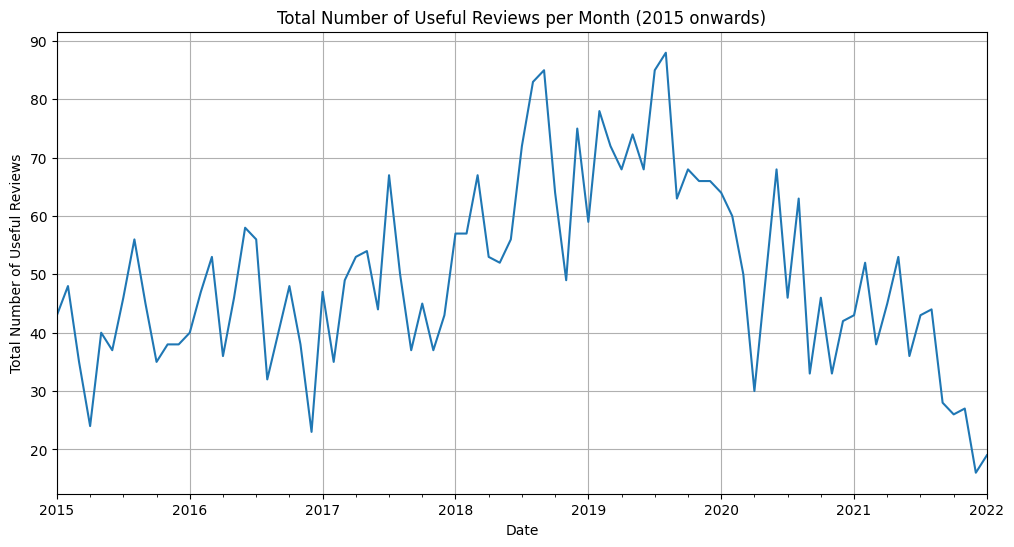

In [ ]:
# prompt: similarly, make a line plot of the total number of USEFUL reviews (at least one person marked it useful) per month over the course of the dataset date field - start from 2015

import matplotlib.pyplot as plt
# Filter for useful reviews (useful > 0)
useful_reviews_df = df_filtered[df_filtered['useful'] > 0].copy()

# Group by month and count useful reviews
monthly_useful_reviews = useful_reviews_df.set_index('date').resample('ME')['review_id'].count()

# Plot the total number of useful reviews per month
plt.figure(figsize=(12, 6))
monthly_useful_reviews.plot(kind='line')
plt.title('Total Number of Useful Reviews per Month (2015 onwards)')
plt.xlabel('Date')
plt.ylabel('Total Number of Useful Reviews')
plt.grid(True)
plt.show()

We observe a very similar trend when it comes to useful reviews (reviews that were voted to be useful by at least one user)

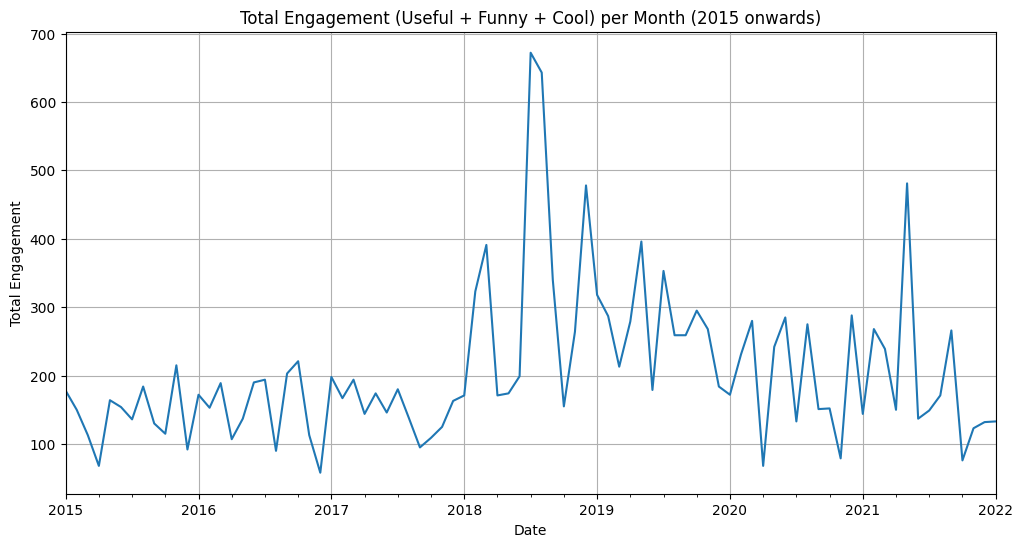

In [ ]:
# prompt: now make a line plot of the total number engagement reviews got (funny, useful or cool all summed up) per month over the course of the dataset date field - start from 2015

import matplotlib.pyplot as plt
# Calculate total engagement (useful + funny + cool)
df_filtered['total_engagement'] = df_filtered['useful'] + df_filtered['funny'] + df_filtered['cool']

# Group by month and sum total engagement
monthly_engagement = df_filtered.set_index('date').resample('M')['total_engagement'].sum()

# Plot the total engagement per month
plt.figure(figsize=(12, 6))
monthly_engagement.plot(kind='line')
plt.title('Total Engagement (Useful + Funny + Cool) per Month (2015 onwards)')
plt.xlabel('Date')
plt.ylabel('Total Engagement')
plt.grid(True)
plt.show()

Reviews from Mid-2018 got many engagements - possibly this is when users wrote the highest quality reviews (in terms of usefullness, coolness and funniness)

### Users

In [ ]:
user_df.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

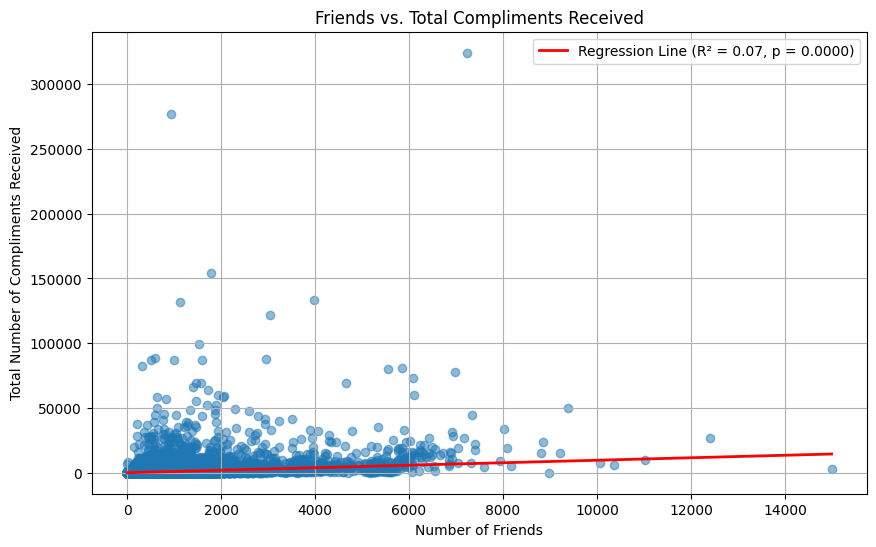

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import numpy as np

# Calculate the total number of compliments for each user
user_df['total_compliments'] = user_df[[
    'compliment_hot', 'compliment_more', 'compliment_profile',
    'compliment_cute', 'compliment_list', 'compliment_note',
    'compliment_plain', 'compliment_cool', 'compliment_funny',
    'compliment_writer', 'compliment_photos'
]].sum(axis=1)

user_df['num_friends'] = user_df['friends'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# Prepare data for the scatter plot
x = user_df['num_friends'].values.reshape(-1, 1)
y = user_df['total_compliments'].values

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(user_df['num_friends'], user_df['total_compliments'], alpha=0.5)
plt.xlabel('Number of Friends')
plt.ylabel('Total Number of Compliments Received')
plt.title('Friends vs. Total Compliments Received')
plt.grid(True)

# Perform linear regression using sklearn to get R2
model_sk = LinearRegression()
model_sk.fit(x, y)
y_pred_sk = model_sk.predict(x)
r2_sk = r2_score(y, y_pred_sk)

# Perform regression using statsmodels to get p-value
X_sm = sm.add_constant(x)  # Add an intercept term to the independent variable
model_sm = sm.OLS(y, X_sm).fit()
p_value = model_sm.pvalues[1] # p-value for the num_friends coefficient

# Plot the regression line
plt.plot(x, y_pred_sk, color='red', linewidth=2, label=f'Regression Line (R² = {r2_sk:.2f}, p = {p_value:.4f})')

# Add legend
plt.legend(loc="upper right")

plt.show()

As expected, the number of friends is statistically significantly associated with the number of compliments received :)

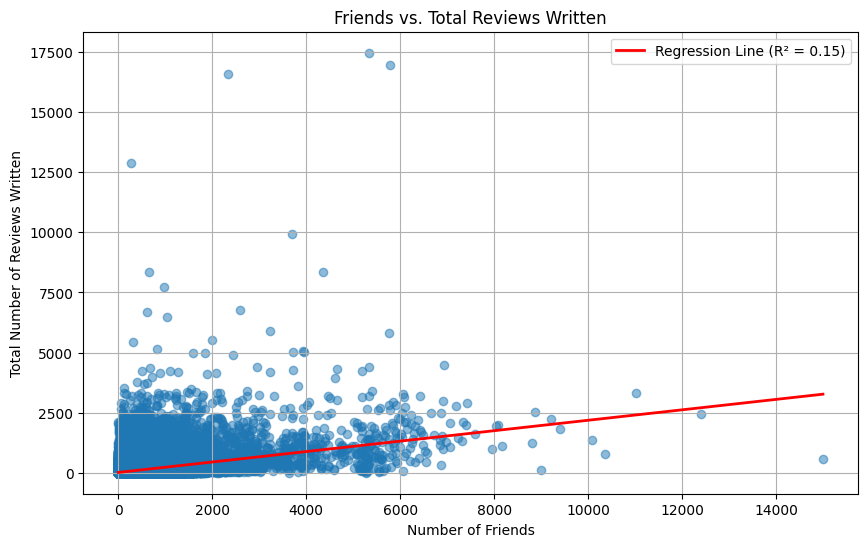

In [ ]:
# prompt: make a scatter plot with regression line and R2 to understand if users with more friends write more reviews - include all types of compliments and use the review count from user_df (no need to merge) - use matplotlib

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

user_df['num_friends'] = user_df['friends'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# Prepare data for the scatter plot
x = user_df['num_friends'].values.reshape(-1, 1)
y = user_df['review_count'].values

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(user_df['num_friends'], user_df['review_count'], alpha=0.5)
plt.xlabel('Number of Friends')
plt.ylabel('Total Number of Reviews Written')
plt.title('Friends vs. Total Reviews Written')
plt.grid(True)

# Perform linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Plot the regression line
plt.plot(x, y_pred, color='red', linewidth=2, label=f'Regression Line (R² = {r2:.2f})')

# Add legend
plt.legend(loc="upper right")

plt.show()

Similarly, the more friends you add on Yelp, the more invested you are to write reviews - essentially adding friends and interacting with them on the platform incentivizes you to write more reviews

In [ ]:
#now let's find out specifically if users on average give out better or worse ratings for restaurants in Largo, FL than their usual average star rating

restaurant_user = df.merge(user_df[['user_id', 'average_stars']], left_on = 'user_id', right_on = 'user_id', how='left')

In [ ]:
star_df = restaurant_user.groupby('user_id').aggregate({'stars': 'mean', 'average_stars': 'first'})

In [ ]:
star_df.columns = ['Largo_restaurant_avg_stars', 'avg_stars']

In [ ]:
star_df['Largo_sentiment'] = star_df['Largo_restaurant_avg_stars'] - star_df['avg_stars']

<Axes: >

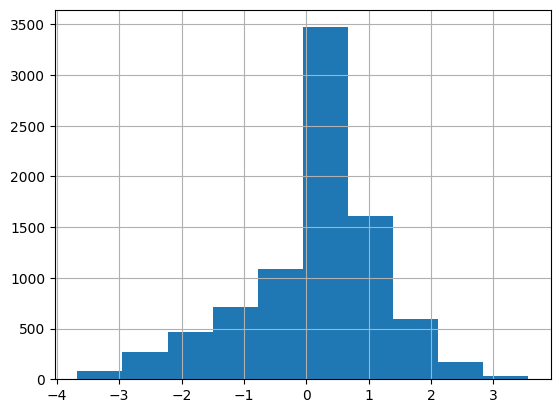

In [ ]:
star_df['Largo_sentiment'].hist()

In [ ]:
star_df['Largo_sentiment'].describe()

count    8481.000000
mean        0.086317
std         1.103539
min        -3.670000
25%        -0.330000
50%         0.000000
75%         0.750000
max         3.560000
Name: Largo_sentiment, dtype: float64

Among the 8481 users reviewing Largo restaurants, some have given worse average ratings to these places than their overall average rating given to any business on Yelp and some have given better ratings on average to restaurants in Largo than their all-time average for all businesses on Yelp. On average, most users give slightly better ratings for Largo restaurants (0.086 more stars).

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


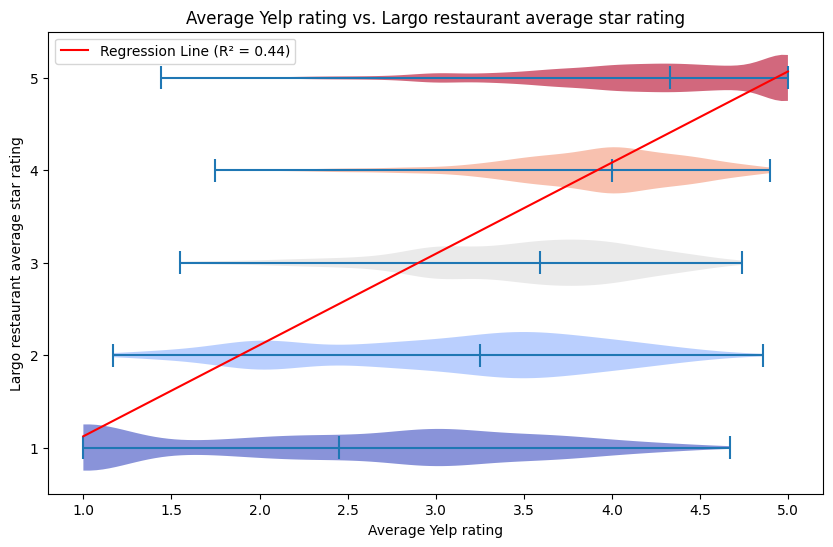

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.figure(figsize=(10, 6))

# Prepare data for each star rating
star_levels = [1, 2, 3, 4, 5]
data_per_star = [star_df[star_df['Largo_restaurant_avg_stars'] == star]['avg_stars'].values for star in star_levels]

# Make sure empty stars (with no reviews) are represented as empty arrays
data_per_star = [x if len(x) > 0 else np.array([np.nan]) for x in data_per_star]

# Plot horizontal violins
parts = plt.violinplot(
    data_per_star,
    positions=star_levels,
    vert=False,
    showmeans=False,
    showmedians=True
)

# Optional: Color the violins by rating (just for aesthetics)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(star_levels)))
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.6)

# Fit linear regression
X = star_df[['avg_stars']]
y = star_df['Largo_restaurant_avg_stars']
model = LinearRegression()
model.fit(X, y)
x_line = np.linspace(star_df['avg_stars'].min(), star_df['avg_stars'].max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)
r2 = r2_score(y, model.predict(X))

# Plot regression line: Note we have to invert axes for horizontal violin
plt.plot(x_line, y_line, color='red', linestyle='-', label=f'Regression Line (R² = {r2:.2f})')

plt.title('Average Yelp rating vs. Largo restaurant average star rating')
plt.xlabel('Average Yelp rating')
plt.ylabel('Largo restaurant average star rating')
plt.yticks(star_levels)
plt.ylim(0.5, 5.5)  # 1 at bottom, 5 at top

plt.legend()
plt.show()

People with higher average star ratings given are more likely to give higher ratings for Largo restaurants too

### Businesses

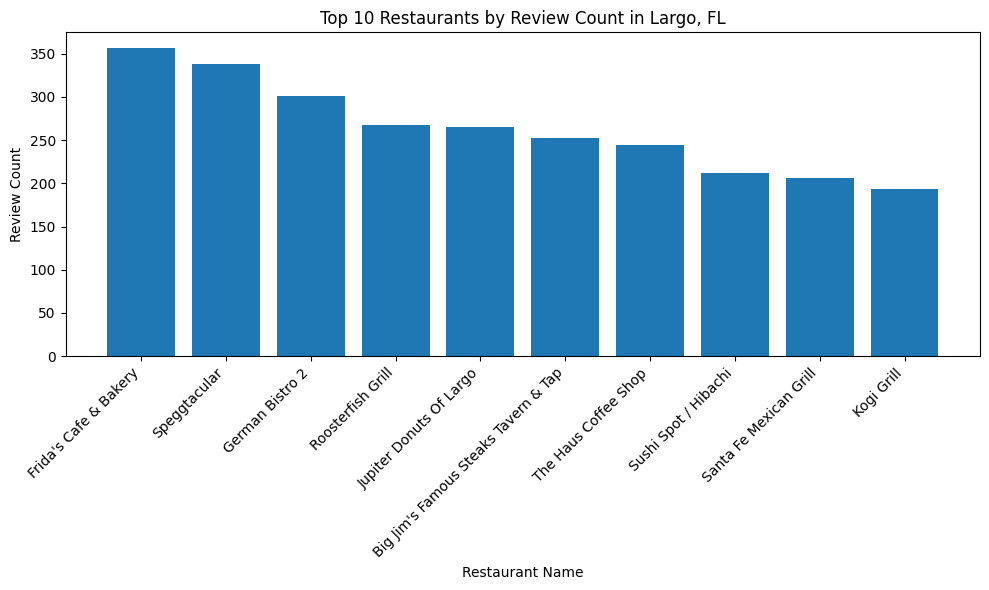

In [ ]:
# prompt: make a bar graph showing the top 10 restaurants in terms of review count

import matplotlib.pyplot as plt
# Make a bar graph showing the top 5 restaurants in terms of review count
top_10_restaurants = rest.sort_values(by='review_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_restaurants['name'], top_10_restaurants['review_count'])
plt.xlabel('Restaurant Name')
plt.ylabel('Review Count')
plt.title('Top 10 Restaurants by Review Count in Largo, FL')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

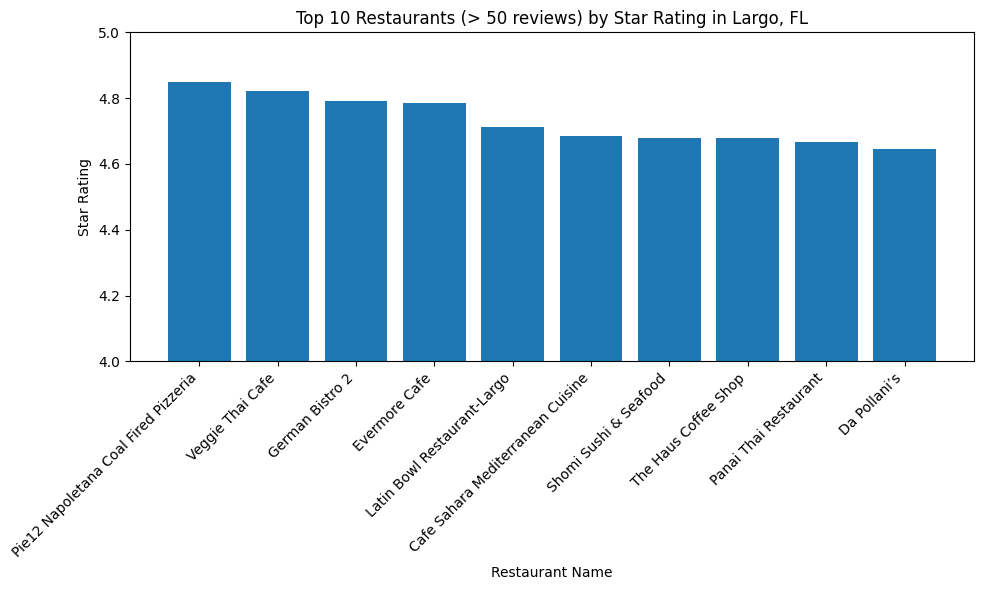

In [ ]:
# prompt: make a bar graph showing the top 10 restaurants in terms of star rating (only consider those with over 50 reviews)
#Note: using the review dataset here to get more accurate review information that is not rounded to nearest half star (see sanity check section above)

import matplotlib.pyplot as plt
# Filter restaurants with over 50 reviews
restaurants_over_50_reviews = merged_check[merged_check['review_count_review'] > 50].copy()

# Sort by stars and get the top 10
top_10_by_stars = restaurants_over_50_reviews.sort_values(by='stars_review', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_by_stars['name'], top_10_by_stars['stars_review'])
plt.xlabel('Restaurant Name')
plt.ylabel('Star Rating')
plt.title('Top 10 Restaurants (> 50 reviews) by Star Rating in Largo, FL')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.ylim([4,5])
plt.show()

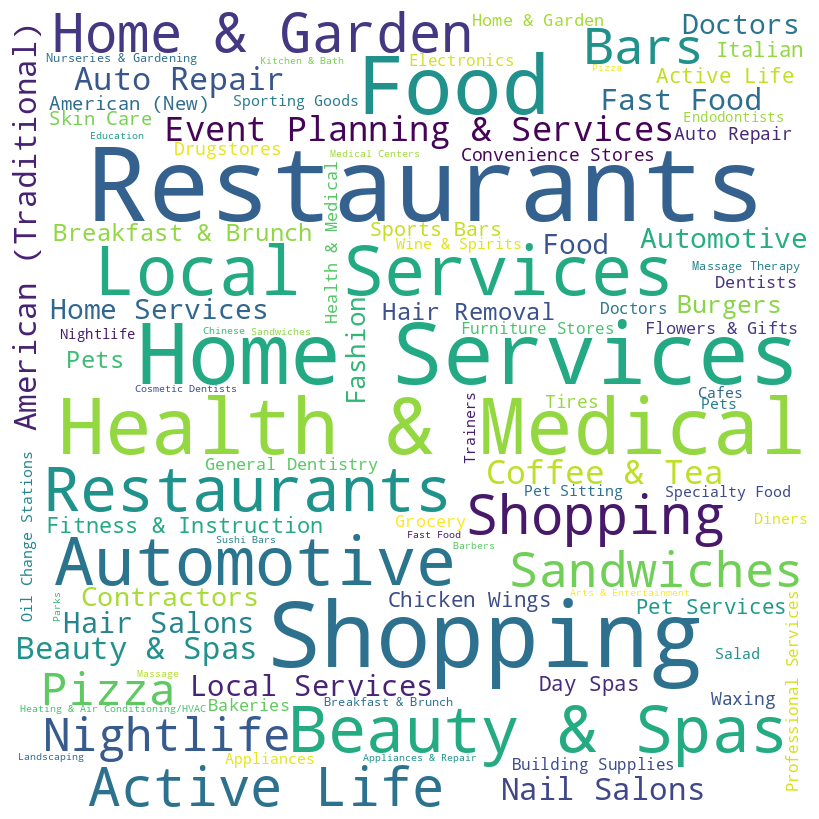

In [ ]:
# prompt: generate a word cloud from dups.value_counts().to_dict() which shows the number of businesses in a given category in Largo, FL
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(dups.value_counts().to_dict())

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

The above graph shows the most typical types of businesses in Largo, FL

## Analysis of reviews of operating restaurants in Largo, FL using techniques discussed in class

### Setup

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Regex, tokenize, PoS and lemmatize to clean data

In [ ]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Load stop words
stop_words = set(stopwords.words('english'))

In [ ]:
#as discussed in class
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters and punctuation
    tokens = word_tokenize(text) # Tokenize text
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    return tokens

In [ ]:
#as discussed in class
def lemmatize_tokens(tokens):
    pos_tags = pos_tag(tokens) #part of speech
    lemmatized_tokens = []
    for token, tag in pos_tags:
        pos = tag[0].lower()
        if pos in ['a', 'r', 'n', 'v']: #adjective, adverb, noun, verb - these can be passed to the lemmatizer to make lemmatizing more accurate
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos))
        else: #otherwise pass to lemmatizer without PoS
            lemmatized_tokens.append(lemmatizer.lemmatize(token))
    return lemmatized_tokens

In [ ]:
#And save the columns in a new column named 'Cleaned Tokens' and 'Lemmatized Tokens'
df.loc[:, 'Cleaned Tokens'] = df['text'].apply(clean_text)
df.loc[:, 'Lemmatized Tokens'] = df['Cleaned Tokens'].apply(lemmatize_tokens)

### ngrams

In [ ]:
#as discussed in class
def generate_bigrams(tokens):
    bigrams = ngrams(tokens, 2)
    return list(bigrams)

In [ ]:
#as discussed in class
def generate_trigrams(tokens):
    trigrams = ngrams(tokens, 3)
    return list(trigrams)

In [ ]:
#Generate bigrams and trigrams
df['Bigrams'] = df['Lemmatized Tokens'].apply(generate_bigrams)
df['Trigrams'] = df['Lemmatized Tokens'].apply(generate_trigrams)
df.head(5)

/tmp/ipython-input-143-2860035923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bigrams'] = df['Lemmatized Tokens'].apply(generate_bigrams)
/tmp/ipython-input-143-2860035923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trigrams'] = df['Lemmatized Tokens'].apply(generate_trigrams)


review_id                 user_id             business_id  \
1735  Au_hzNqry6cPlnUGklB8QQ  lE5pLYWxkjhwwNywRc5q_Q  pjb3xGA9ccjl49B5ERH46w   
2857  0t9rdI5VQyVqSv3HWsthlg  GaA9W7Nhw3NAoSBHi7RQYA  M1BkW7JZZBrCfT4_Sr4NEQ   
3453  FkIUt1u7hopE9YUIcNm4qw  bnA5znt3FNwrnP9iLCKAbA  M1BkW7JZZBrCfT4_Sr4NEQ   
3803  LD4tVhoQtwl_U15fP2sBEA  -P2N8a5DytbkW9V66-CjIQ  _PiS4MmBmQmkOoLmo1p31A   
4939  acmWVnFtquynKvxM13YYww  jyqWaHcqPCC_R5y0BDBUBg  M1BkW7JZZBrCfT4_Sr4NEQ   

      stars  useful  funny  cool  \
1735    1.0       0      0     0   
2857    5.0       0      0     0   
3453    5.0       0      0     0   
3803    3.0       0      0     1   
4939    5.0       0      0     0   

                                                   text                 date  \
1735  Spent way too much money to get actually spoil...  2017-09-20 17:10:01   
2857  Delicious both the burritos and Vietnamese! Co...  2018-06-09 02:10:36   
3453  I was fortunate to come across this lovely pla...  2017-07-08 20:49:07   
3803  Incredible wine and booze selections. Clean an...  2014-04-01 14:49:40   
4939  Such a great spot!!! Authentic, amazing food w...  2018-05-29 00:02:54   

                                         Cleaned Tokens  \
1735  [spent, way, much, money, get, actually, spoil...   
2857  [delicious, burritos, vietnamese, come, often,...   
3453  [fortunate, come, across, lovely, place, sushi...   
3803  [incredible, wine, booze, selections, clean, o...   
4939  [great, spot, authentic, amazing, food, many, ...   

                                      Lemmatized Tokens  \
1735  [spent, way, much, money, get, actually, spoil...   
2857  [delicious, burrito, vietnamese, come, often, ...   
3453  [fortunate, come, across, lovely, place, sushi...   
3803  [incredible, wine, booze, selection, clean, or...   
4939  [great, spot, authentic, amaze, food, many, op...   

                                                Bigrams  \
1735  [(spent, way), (way, much), (much, money), (mo...   
2857  [(delicious, burrito), (burrito, vietnamese), ...   
3453  [(fortunate, come), (come, across), (across, l...   
3803  [(incredible, wine), (wine, booze), (booze, se...   
4939  [(great, spot), (spot, authentic), (authentic,...   

                                               Trigrams  
1735  [(spent, way, much), (way, much, money), (much...  
2857  [(delicious, burrito, vietnamese), (burrito, v...  
3453  [(fortunate, come, across), (come, across, lov...  
3803  [(incredible, wine, booze), (wine, booze, sele...  
4939  [(great, spot, authentic), (spot, authentic, a...

In [ ]:
#as discussed in class
# Flatten the list of words, bigrams and trigrams for frequency analysis (long coding box)
all_words = [word for sublist in df['Lemmatized Tokens'] for word in sublist]
all_bigrams = [bigram for sublist in df['Bigrams'] for bigram in sublist]
all_trigrams = [trigram for sublist in df['Trigrams'] for trigram in sublist]

In [ ]:
#as discussed in class
# Calculate the frequency distribution
word_freq = Counter(all_words)
bigram_freq = Counter(all_bigrams)
trigram_freq = Counter(all_trigrams)

In [ ]:
#as discussed in class
# Display the most common bigrams and unigrams
print("Most Common Words:", word_freq.most_common(10))
print("Most Common Bigrams:", bigram_freq.most_common(10))
print("Most Common Trigrams:", trigram_freq.most_common(10))

Most Common Words: [('food', 9365), ('good', 7349), ('place', 7188), ('order', 6951), ('get', 5944), ('go', 5850), ('great', 5447), ('time', 4602), ('service', 4274), ('come', 4115)]
Most Common Bigrams: [(('go', 'back'), 935), (('come', 'back'), 735), (('first', 'time'), 627), (('highly', 'recommend'), 529), (('really', 'good'), 501), (('food', 'good'), 498), (('customer', 'service'), 485), (('great', 'food'), 460), (('good', 'food'), 414), (('food', 'great'), 365)]
Most Common Trigrams: [(('definitely', 'come', 'back'), 121), (('definitely', 'go', 'back'), 120), (('key', 'lime', 'pie'), 82), (('food', 'great', 'service'), 81), (('cant', 'go', 'wrong'), 76), (('great', 'food', 'great'), 73), (('wait', 'go', 'back'), 73), (('would', 'highly', 'recommend'), 69), (('go', 'back', 'try'), 69), (('never', 'go', 'back'), 69)]


In [ ]:
#as discussed in class
# Convert list of tuples into a dictionary - long coding box
word_freq_dict = dict(word_freq)
ngram_freq_dict = {'_'.join(bigram): count for bigram, count in bigram_freq.items()}

In [ ]:
#create the world cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
ngramcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_freq_dict)

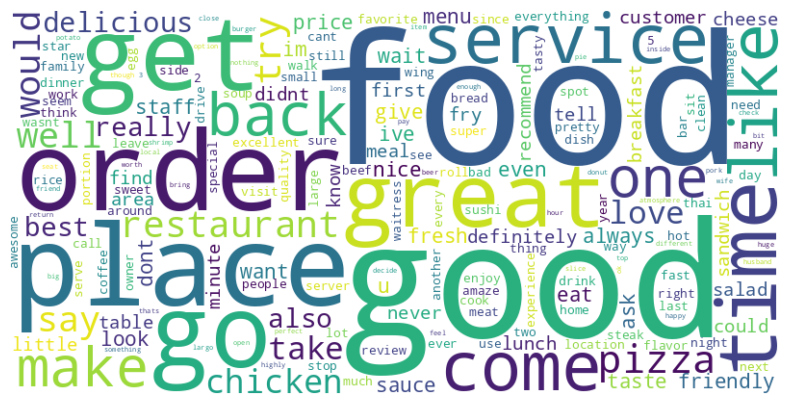

In [ ]:
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

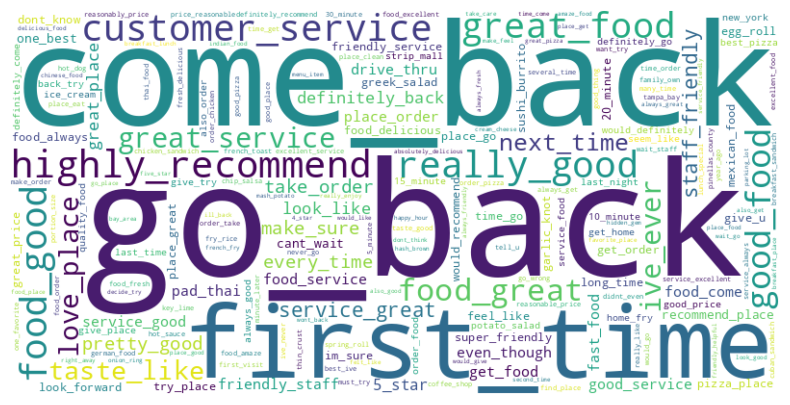

In [ ]:
# Display bigram cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(ngramcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/personal stuff/Social media/YelpReviewLargoRestaurants.csv')

### BoW (will result in the same most common words as ngrams analysis)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/personal stuff/Social media/YelpReviewLargoRestaurants.csv', index_col=0)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.01) #words, bigrams and trigrams that appear in at least 1% of the reviews
X = vectorizer.fit_transform(df['Lemmatized Tokens']) #using the cleaned lemmatized tokens
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bow_df.sum(axis=0).sort_values(ascending=False).head(5) #indeed gives the same result as in the ngrams analysis above

food     9365
good     7349
place    7188
order    6951
get      5944
dtype: int64

### TFIDF (if we wanted to analyse a specific review)

In [ ]:
#as discussed in class
# Initialize TfidfVectorizer for words, bigrams and trigrams and setting the threshold
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df = 0.01)

# Fit and transform the text data
X = vectorizer.fit_transform(df['Lemmatized Tokens'])

# Create a DataFrame with the TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_df

10  10 minute   12   15   20  20 minute        30        45  able  \
0      0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
1      0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
2      0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
3      0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
4      0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
...    ...        ...  ...  ...  ...        ...       ...       ...   ...   
13570  0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
13571  0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
13572  0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.000000   0.0   
13573  0.0        0.0  0.0  0.0  0.0        0.0  0.164506  0.000000   0.0   
13574  0.0        0.0  0.0  0.0  0.0        0.0  0.000000  0.164991   0.0   

       absolutely  ...  year  yelp  yes       yet  york  youll  young  youre  \
0             0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
1             0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
2             0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
3             0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
4             0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
...           ...  ...   ...   ...  ...       ...   ...    ...    ...    ...   
13570         0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
13571         0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
13572         0.0  ...   0.0   0.0  0.0  0.151339   0.0    0.0    0.0    0.0   
13573         0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   
13574         0.0  ...   0.0   0.0  0.0  0.000000   0.0    0.0    0.0    0.0   

           yum  yummy  
0      0.00000    0.0  
1      0.00000    0.0  
2      0.00000    0.0  
3      0.00000    0.0  
4      0.00000    0.0  
...        ...    ...  
13570  0.14646    0.0  
13571  0.00000    0.0  
13572  0.00000    0.0  
13573  0.00000    0.0  
13574  0.00000    0.0  

[13575 rows x 766 columns]

In [ ]:
# Get the highest TF-IDF scores
def get_top_n_tfidf_words(row, n=5):
    row = row.sort_values(ascending=False)
    return list(zip(row.index, row.values))[:n]

In [ ]:
#check the first 5 reviews
top_n_words = tfidf_df.apply(lambda row: get_top_n_tfidf_words(row), axis=1)
for word in top_n_words[:10]:
  print(word[0:5])

[('deliver', np.float64(0.36833451574091836)), ('money', np.float64(0.3492076317921268)), ('actually', np.float64(0.33834592072123715)), ('order', np.float64(0.3359632468781847)), ('return', np.float64(0.30617799569449966))]
[('burrito', np.float64(0.6254862095904429)), ('pho', np.float64(0.36185362290692735)), ('often', np.float64(0.3292380641016954)), ('today', np.float64(0.2890834485653305)), ('first time', np.float64(0.2776774091637527))]
[('sushi', np.float64(0.35722555276752566)), ('like', np.float64(0.29671311683002566)), ('ingredient', np.float64(0.28206934094101443)), ('burrito', np.float64(0.2719449474525068)), ('overall', np.float64(0.2616454231410552))]
[('incredible', np.float64(0.41975263881501657)), ('wine', np.float64(0.4062765649863775)), ('terrible', np.float64(0.3781090023228603)), ('florida', np.float64(0.3629430954751886)), ('selection', np.float64(0.3405281805859524))]
[('super friendly', np.float64(0.324838372700431)), ('friendly staff', np.float64(0.301951420016

In [ ]:
import re
from nltk.util import ngrams
from IPython.display import display, HTML

# Choose a review index to visualize
review_idx = 0  # Change this to see a different review

# Get the lemmatized tokens and original text for this review
review_lemmas = df.iloc[review_idx]['Lemmatized Tokens']
review_display = df.iloc[review_idx]['text'] if 'text' in df.columns else review_lemmas

# Get feature names and the tfidf vector for this review
feature_names = vectorizer.get_feature_names_out()
tfidf_vector = tfidf_df.iloc[review_idx].values

# Tokenize
tokens = re.findall(r'\b\w+\b', review_lemmas.lower()) #Turns the lemmatized review into a list of individual words (tokens)
max_n = 3  # up to trigrams

# Build n-gram score mapping (longest n-grams first)
ngram_scores = {}
for n in range(max_n, 0, -1): #Iterate over n-grams from largest to smallest (trigram → bigram → unigram)
    for ng in ngrams(tokens, n): #For each n-gram of size n in the tokens (ngrams(tokens, n) slides a window of size n over the tokens)
        ngram_str = ' '.join(ng) #Join n-gram tokens into a phrase
        if ngram_str in feature_names: #Check if the n-gram phrase is a feature in your TF-IDF vectorizer (Only keep n-grams that are in the trained vocabulary)
            idx_col = list(feature_names).index(ngram_str)
            score = tfidf_vector[idx_col] #Get the TF-IDF score for this n-gram in the review
            if score > 0: #Only include those n-grams that actually appear in this review with a nonzero TF-IDF score
                ngram_scores[ngram_str] = score

max_score = max(ngram_scores.values())

def tfidf_to_color(score, max_score):
    # Linear white-to-red
    intensity = int(255 * score / max_score) if max_score > 0 else 0
    return f"rgb(255,{255-intensity},{255-intensity})"

# Highlight n-grams in the original review, longest first (to avoid overlap)
#Why longest ngrams first?
#If a phrase like "fast service" (bigram) is in the text and also appears as a unigram ('fast' or 'service'), we want to highlight the entire phrase first before considering the single words, to avoid overlapping HTML coloring.
#Trigrams are assumed to be more accurate for importance than bigrams as they are more specific - similarly bigrams are assumed to be more accurate than single words
highlighted = review_display
for ng in sorted(ngram_scores, key=lambda x: -len(x)):
    color = tfidf_to_color(ngram_scores[ng], max_score)
    # Replace spaces in the n-gram with ~ so it won't be matched again
    ng_marked = ng.replace(' ', '~')
    highlighted = re.sub(
        fr'\b{re.escape(ng)}\b',
        f'<span style="background-color:{color}">{ng_marked}</span>',
        highlighted,
        flags=re.IGNORECASE
    )
    #sequence is now separated by '~', and further regex passes will not match bigrams or single words inside it

def restore_spaces_in_spans(match):
    # Only replace ~ with spaces inside the span
    content = match.group(1).replace('~', ' ')
    return f'<span style="background-color:{match.group(2)}">{content}</span>'

# Replaces content inside span tags only
highlighted = re.sub(
    r'<span style="background-color:([^"]+)">([^<]+)</span>',
    lambda m: f'<span style="background-color:{m.group(1)}">{m.group(2).replace("~", " ")}</span>',
    highlighted
)

display(HTML(highlighted))

### Topic modelling

In [ ]:
!pip uninstall -y numpy scipy thinc gensim --quiet
!pip install numpy==1.26.4 scipy==1.13.1 gensim==4.3.3 scikit-learn thinc==8.3.6 --no-deps --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 133.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 99.2 MB/s eta 0:00:00


In [ ]:
!pip install squarify vaderSentiment --quiet

In [ ]:
!pip install --upgrade matplotlib seaborn scikit-learn gensim pandas --quiet #restart session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from nltk import pos_tag
import pandas as pd
import squarify
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#re-loading dataset after restarting the session
df = pd.read_csv('/content/drive/MyDrive/personal stuff/Social media/YelpReviewLargoRestaurants.csv', index_col=0)

In [ ]:
#as discussed in class
#creating sparse corpus
vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.01) #including bigrams and trigrams and require to appear in at least 1% of documents
X = vectorizer.fit_transform(df['Lemmatized Tokens'])
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [ ]:
#mapping between index and word
id2word = corpora.Dictionary([vectorizer.get_feature_names_out()])

In [ ]:
#Latent Dirichlet Allocation model training
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=15)

In [ ]:
#as discussed in class
# `num_words=10`: The number of top words to display for each topic
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)
    # `topic_terms` is a string with the top `num_words` words and their probabilities

(0, '0.024*"pizza" + 0.023*"good" + 0.017*"chicken" + 0.017*"order" + 0.013*"like" + 0.013*"sauce" + 0.013*"get" + 0.012*"place" + 0.011*"salad" + 0.011*"try"')
(1, '0.037*"food" + 0.036*"great" + 0.028*"place" + 0.025*"good" + 0.020*"service" + 0.015*"friendly" + 0.014*"love" + 0.013*"delicious" + 0.012*"staff" + 0.011*"always"')
(2, '0.028*"order" + 0.020*"get" + 0.020*"go" + 0.019*"food" + 0.017*"time" + 0.013*"say" + 0.012*"come" + 0.012*"take" + 0.011*"one" + 0.011*"back"')


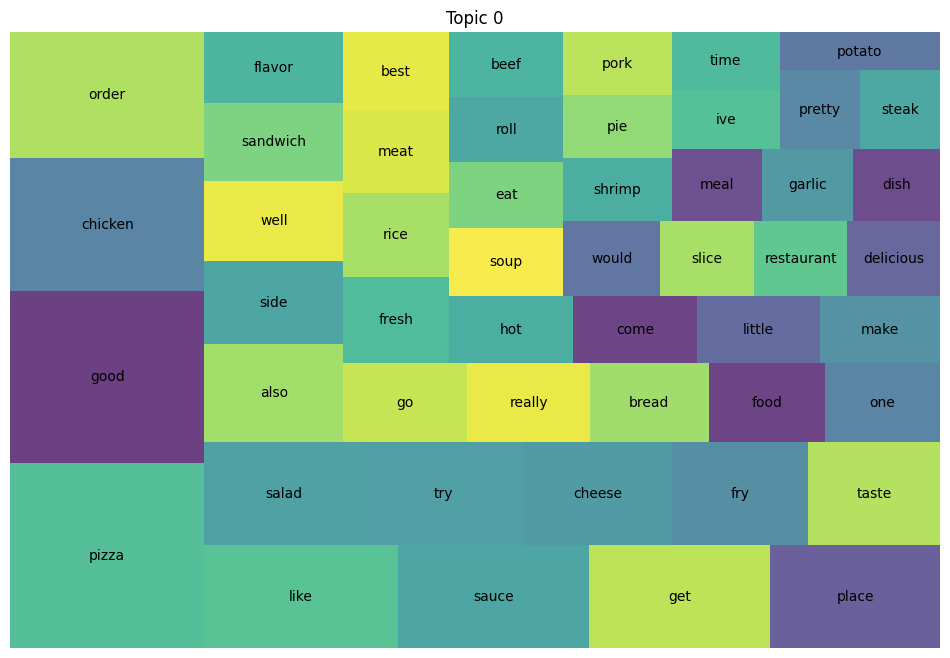

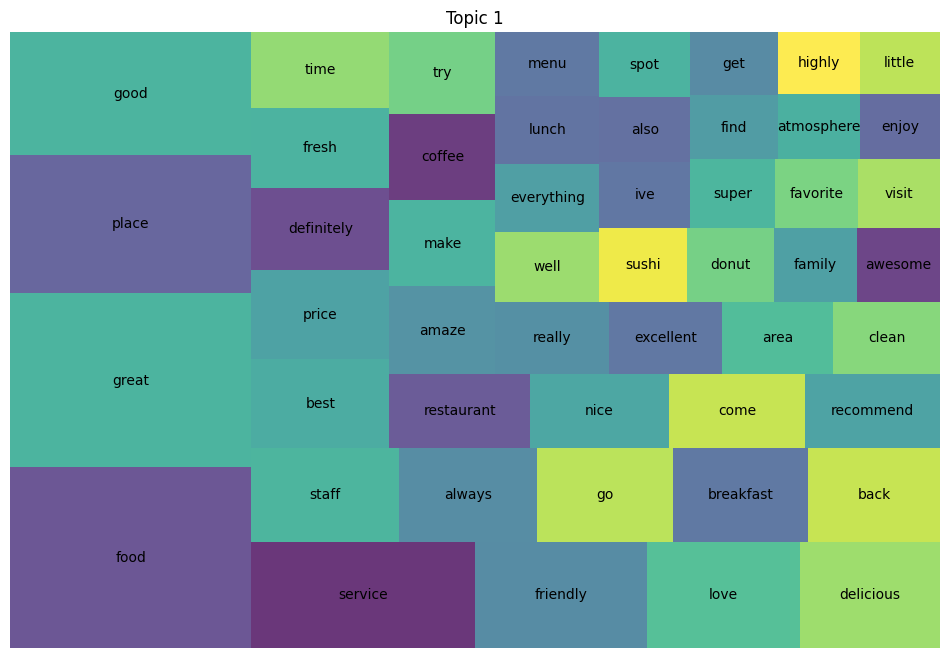

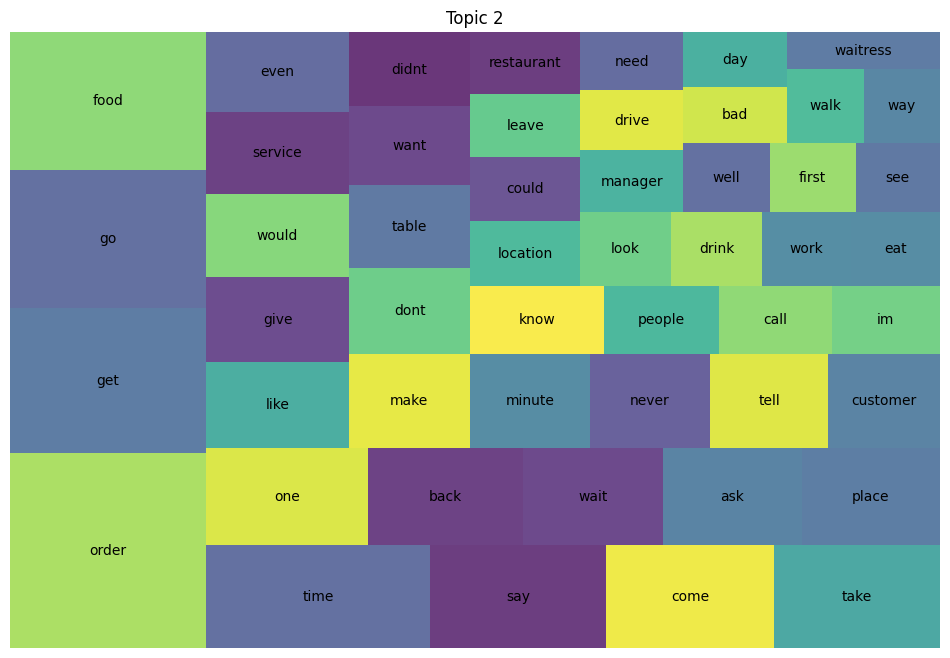

In [ ]:
#as discussed in class
#visualization
topics = lda.show_topics(formatted=False, num_words=50)

def extract_word_frequencies(topics):
    word_freqs = []
    for topic in topics:
        word_freq = {word: weight for word, weight in topic[1]}
        word_freqs.append(word_freq)
    return word_freqs

word_freqs = extract_word_frequencies(topics)

# Plot treemaps for each topic
def plot_treemap(word_freq, topic_num):
    labels = list(word_freq.keys())
    sizes = list(word_freq.values())

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=.8)
    plt.title(f'Topic {topic_num}')
    plt.axis('off')
    plt.show()

for i, word_freq in enumerate(word_freqs):
    plot_treemap(word_freq, i)

as the plots show the 3 distinct topics are:
- Topic 1: food items like potato, steak, pork, garlic, bread, soup, shrimp, etc
- Topic 2: feelings invoked by the restaurant: amaze, super, favorite, enjoy, athmosphere, best, etc
- Topic 3: restaurant employees and experience other than food: manager, minute, waitress, order, wait, people, location etc

### Sentiment analysis

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
!pip install squarify vaderSentiment --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
#using uncleaned text here and caps and even spelling mistakes can shed light on sentiment
#calculating vader sentiment
df['vader_sentiment'] = df.text.apply(lambda x: sid.polarity_scores(x)['compound'])

/tmp/ipython-input-39-1545722127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vader_sentiment'] = df.text.apply(lambda x: sid.polarity_scores(x)['compound'])


In [ ]:
df['vader_sentiment'].describe()

count    13575.000000
mean         0.620366
std          0.572882
min         -0.997200
25%          0.612350
50%          0.906000
75%          0.963900
max          0.999400
Name: vader_sentiment, dtype: float64

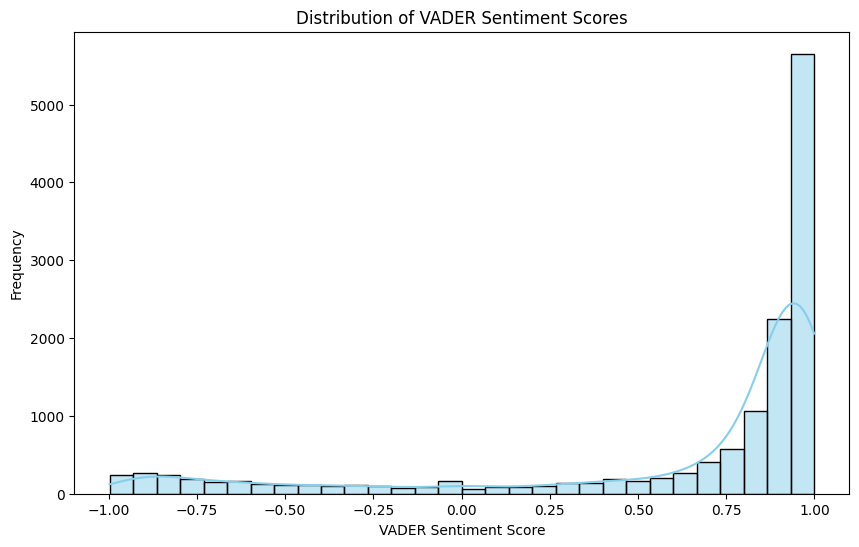

In [ ]:
#visualization of the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Most people who leave review are happy with the restaurant

In [ ]:
#stats on the star ratings given
#again, most people seem to be giving good star rating with an average of 3.78
df['stars'].describe()

count    13575.000000
mean         3.781510
std          1.501975
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars, dtype: float64

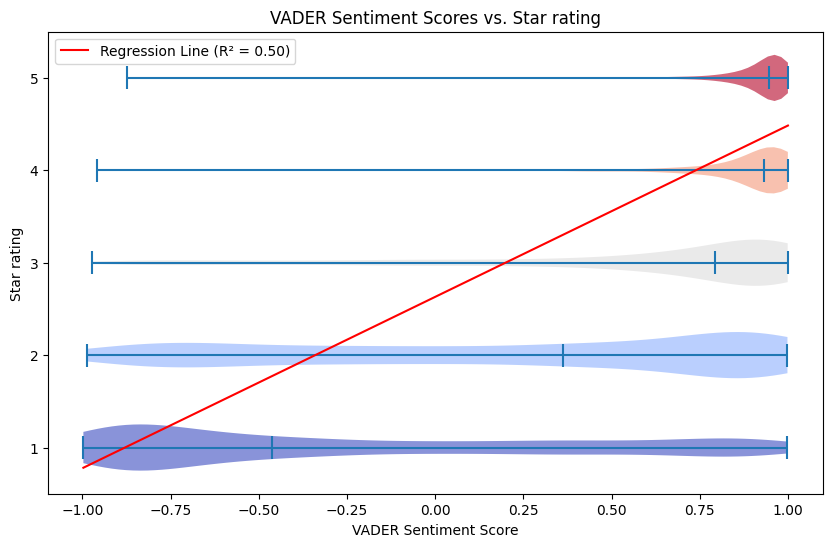

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.figure(figsize=(10, 6))

# Prepare data for each star rating
star_levels = [1, 2, 3, 4, 5]
data_per_star = [df[df['stars'] == star]['vader_sentiment'].values for star in star_levels]

# Make sure empty stars (with no reviews) are represented as empty arrays
data_per_star = [x if len(x) > 0 else np.array([np.nan]) for x in data_per_star]

# Plot horizontal violins
parts = plt.violinplot(
    data_per_star,
    positions=star_levels,
    vert=False,
    showmeans=False,
    showmedians=True
)

# Optional: Color the violins by rating (just for aesthetics)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(star_levels)))
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.6)

# Fit linear regression
X = df[['vader_sentiment']]
y = df['stars']
model = LinearRegression()
model.fit(X, y)
x_line = np.linspace(df['vader_sentiment'].min(), df['vader_sentiment'].max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)
r2 = r2_score(y, model.predict(X))

# Plot regression line: Note we have to invert axes for horizontal violin
plt.plot(x_line, y_line, color='red', linestyle='-', label=f'Regression Line (R² = {r2:.2f})')

plt.title('VADER Sentiment Scores vs. Star rating')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Star rating')
plt.yticks(star_levels)
plt.ylim(0.5, 5.5)  # 1 at bottom, 5 at top

plt.legend()
plt.show()

In [ ]:
#seemingly inconsistent star rating with review sentiment
inconsistent = df.loc[(df.vader_sentiment>0.9) & (df.stars==1), 'text']
for text in inconsistent[:5]:
  print(text)
  print('---------------------------------------------------------')

My wife and I always drove by saying someday we should stop.  Well we stopped I. On a Saturday.  The place was not busy, so more options to sit as we seat ourselves.
The atmosphere was not fancy but far from dumpy. They had a nice selection of breakfast and lunch items. As for the prices.. 5 Stars. Great prices.. I decided to get the steak and eggs.  My wife sausage gravy over biscuits and eggs.  
The food came pretty fast.  A different person from who took the order drop tot off.  My wife before the food got there was refilled on her coffee, I still had half of glass of MNt. Dew.  

Ok so the food the steak was just thrown in a frying pan. I asked for med rare... It was well done.  It was so tuff I could not chew and swallow most of it( I have good teeth) The eggs were cooked good.  The sausage gravy tasted like four.
Will the taste of food and constant chewing I finished my soda, my wife her coffee was empty.  I went to set it on the edge so they could see I needed a refill, and the 

For example, 5th (last) review printed shows positive sentiment because the reviewer talks about how much they loved going there, but they recently had a bad experience hence they gave 1 star only.

In [ ]:
#useful review distribution
df['useful'].describe()

count    13575.000000
mean         0.864236
std          2.662915
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         79.000000
Name: useful, dtype: float64

/tmp/ipython-input-48-369290410.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model_sm.pvalues[1] # p-value for the 'useful' coefficient
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


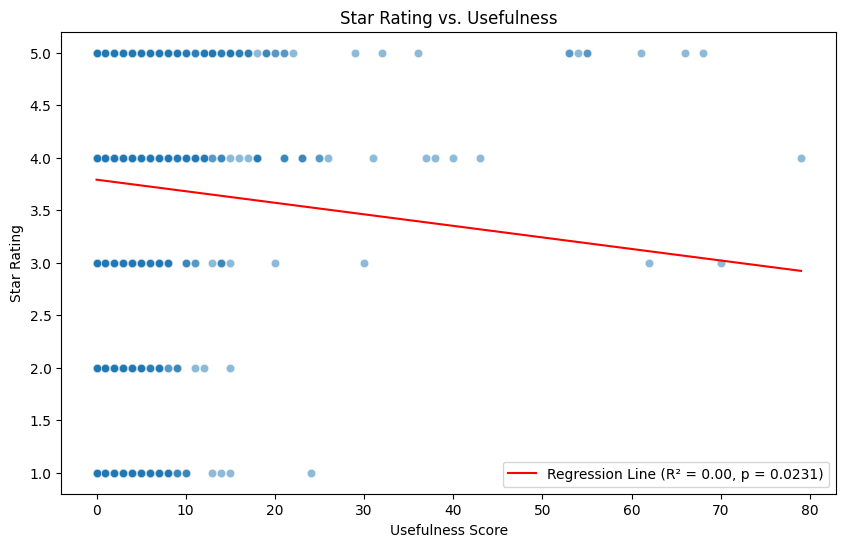

In [ ]:
# prompt: show scatter plot of star rating vs usefulness and fit regression line with R2 displayed

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm # Import statsmodels

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['useful'], y=df['stars'], alpha=0.5)

# Prepare data for regression
X = df[['useful']]
y = df['stars']

# Fit linear regression using sklearn for R2
model_sk = LinearRegression()
model_sk.fit(X, y)
y_pred_sk = model_sk.predict(X)
r2_sk = r2_score(y, y_pred_sk)

# Fit regression using statsmodels for p-value
X_sm = sm.add_constant(X)  # Add an intercept term
model_sm = sm.OLS(y, X_sm).fit()
p_value = model_sm.pvalues[1] # p-value for the 'useful' coefficient

# Plot regression line
x_line = np.linspace(df['useful'].min(), df['useful'].max(), 100).reshape(-1, 1)
y_line = model_sk.predict(x_line)

plt.plot(x_line, y_line, color='red', linestyle='-', label=f'Regression Line (R² = {r2_sk:.2f}, p = {p_value:.4f})')


plt.title('Star Rating vs. Usefulness')
plt.xlabel('Usefulness Score')
plt.ylabel('Star Rating')
plt.legend()
plt.show()

In [ ]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  stars   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.163
Date:                Thu, 10 Jul 2025   Prob (F-statistic):             0.0231
Time:                        11:35:09   Log-Likelihood:                -24781.
No. Observations:               13575   AIC:                         4.957e+04
Df Residuals:                   13573   BIC:                         4.958e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7910      0.014    279.758      0.000       3.764       3.818
useful        -0.0110      0.005     -2.272      0.023      -0.020      -0.002
==============================================================================
Omnibus:                     2324.138   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2078.507
Skew:                          -0.877   Prob(JB):                         0.00
Kurtosis:                       2.228   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Usefulness seems to be significantly associated with star rating (p-value is 0.02)

/tmp/ipython-input-53-2249075705.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model_sm.pvalues[1] # p-value for the 'useful' coefficient
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


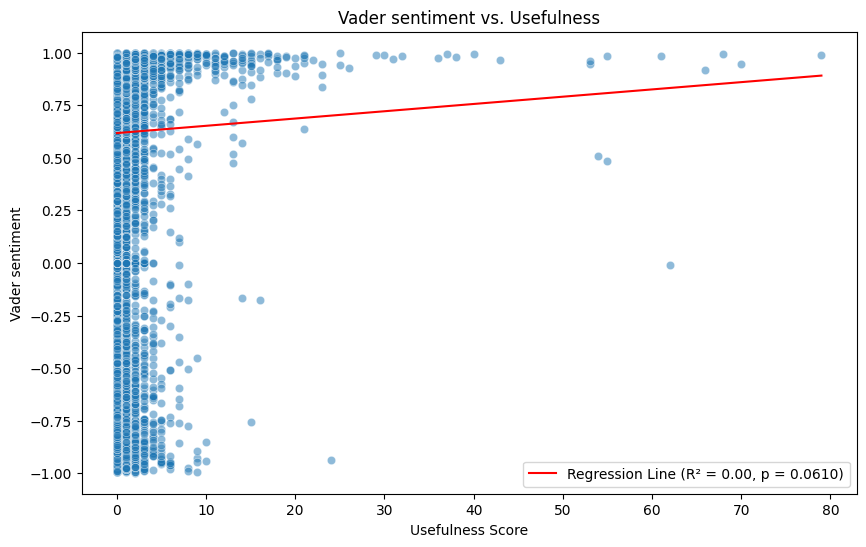

In [ ]:
# prompt: show scatter plot of star rating vs usefulness and fit regression line with R2 displayed

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm # Import statsmodels


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['useful'], y=df['vader_sentiment'], alpha=0.5)

# Fit linear regression using sklearn for R2
X = df[['useful']]
y = df['vader_sentiment']
model_sk = LinearRegression()
model_sk.fit(X, y)
y_pred_sk = model_sk.predict(X)
r2_sk = r2_score(y, y_pred_sk)

# Fit regression using statsmodels for p-value
X_sm = sm.add_constant(X)  # Add an intercept term
model_sm = sm.OLS(y, X_sm).fit()
p_value = model_sm.pvalues[1] # p-value for the 'useful' coefficient


# Plot regression line
x_line = np.linspace(df['useful'].min(), df['useful'].max(), 100).reshape(-1, 1)
y_line = model_sk.predict(x_line)

plt.plot(x_line, y_line, color='red', linestyle='-', label=f'Regression Line (R² = {r2_sk:.2f}, p = {p_value:.4f})')

plt.title('Vader sentiment vs. Usefulness')
plt.xlabel('Usefulness Score')
plt.ylabel('Vader sentiment')
plt.legend()
plt.show()

In [ ]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        vader_sentiment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.510
Date:                Thu, 10 Jul 2025   Prob (F-statistic):             0.0610
Time:                        11:37:11   Log-Likelihood:                -11698.
No. Observations:               13575   AIC:                         2.340e+04
Df Residuals:                   13573   BIC:                         2.341e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6174      0.005    119.439      0.000       0.607       0.628
useful         0.0035      0.002      1.874      0.061      -0.000       0.007
==============================================================================
Omnibus:                     3700.537   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7584.183
Skew:                          -1.690   Prob(JB):                         0.00
Kurtosis:                       4.406   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Usefulness doesn't seem to be significantly associated with vader sentiment (p-value is 0.06)

## Network analysis

In [ ]:
subset_users = user_df.loc[user_df.user_id.isin(df.user_id)]

In [ ]:
#Below code is based on https://www.kaggle.com/code/jagangupta/what-s-in-a-review-yelp-ratings-eda#7.-User-networks:

subset_users.loc[:,'list_friends']=subset_users["friends"].apply(lambda x: str(x).split(','))
subset_users.loc[:,'count_friends']=subset_users["list_friends"].apply(lambda x: len(x))

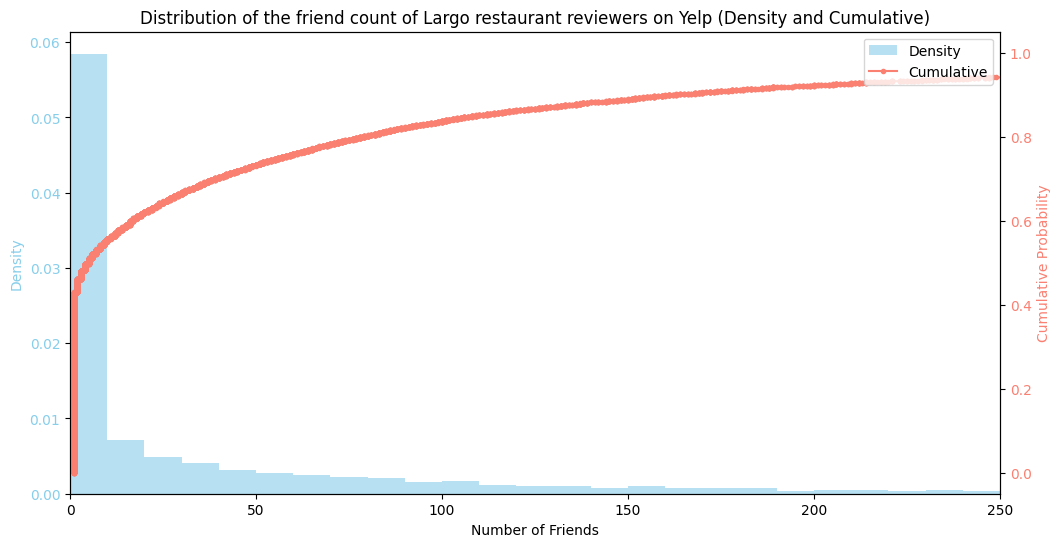

In [ ]:
# prompt: make density and cumulative distribution graph on subset_users.loc[:,'count_friends'] - to show how many people have x amount of friends (okay to use a bin of size 10) and then with the cumulative to show how many people have less than x amount of friends all on the same grapph please - use matplotlib (not sns!) and two different y axis scales so both and density and cumulative are visible - show only up to 500 friends

import matplotlib.pyplot as plt
import numpy as np
# Calculate histogram data for density
hist, bins = np.histogram(subset_users.loc[:,'count_friends'], bins=range(0, 251, 10), density=True)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Calculate cumulative distribution data
sorted_friends = np.sort(subset_users.loc[:,'count_friends'])
cumulative = np.arange(1, len(sorted_friends) + 1) / len(sorted_friends)
cumulative_friends = sorted_friends

# Create figure and primary axes for density
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot density histogram
ax1.bar(bin_centers, hist, width=bins[1]-bins[0], alpha=0.6, color='skyblue', label='Density')
ax1.set_xlabel('Number of Friends')
ax1.set_ylabel('Density', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Distribution of the friend count of Largo restaurant reviewers on Yelp (Density and Cumulative)')
ax1.set_xlim(0, 500) # Set x-axis limit

# Create secondary axes for cumulative distribution
ax2 = ax1.twinx()
ax2.plot(cumulative_friends, cumulative, color='salmon', marker='.', linestyle='-', label='Cumulative')
ax2.set_ylabel('Cumulative Probability', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_xlim(0, 250) # Ensure x-axis limit is consistent

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

In [ ]:
#more than 100 friends - these are influencers!
subset_users.loc[subset_users.count_friends>100]

user_id      name  review_count        yelping_since  \
36       rppTTi-kfF8-qyiArNemag     Helen           460  2006-01-24 14:33:32   
166      YMgZqBUAddmFErxLtCfK_w  Samantha          1985  2009-03-16 23:41:53   
530      zHvS1F_6wOPSLUk6vpDEGA    Taylor          1171  2010-06-30 17:07:11   
778      IyIsFkVY48JWa01inv-7zA       Rob          2904  2008-03-27 14:48:51   
787      a9qfIqE5toA0WgOYTMyw3g    Robert           141  2011-10-02 18:50:14   
...                         ...       ...           ...                  ...   
1853846  4QIt8QR0s7rFIJeJ-Ws_Mw   Giselle            10  2012-08-11 04:06:35   
1857002  7arq8-JPj4_o-SGHtXPMXA     Shäññ             1  2019-07-08 22:18:43   
1864979  Bn4capwl0E3di1O0_PWRKA   Valerie            26  2016-03-04 23:26:01   
1871118  CkgGYMjmHGH1rtk1J5cPbg      Blud             1  2013-10-02 23:19:14   
1872479  1RA13dK9vhb1Hb_qgAvmUQ      Kira             2  2020-03-15 20:31:40   

         useful  funny  cool  \
36          700    149   425   
166        6485   2438  4159   
530        3121   1232  1521   
778        8482   3399  6169   
787         285    273   148   
...         ...    ...   ...   
1853846      13      7     5   
1857002       0      0     0   
1864979      18      2     2   
1871118       0      0     0   
1872479       0      0     0   

                                                     elite  \
36                 2010,2012,2013,2014,2015,2016,2017,2018   
166      2010,2011,2012,2013,2014,2015,2016,2017,2018,2...   
530      2010,2011,2012,2013,2014,2015,2016,2017,2018,2...   
778      2010,2011,2012,2013,2014,2015,2016,2017,2018,2...   
787                                                   2012   
...                                                    ...   
1853846                                                      
1857002                                                      
1864979                                                      
1871118                                                      
1872479                                                      

                                                   friends  fans  ...  \
36       HzoQKKHDq9BI37dyJAAtGA, Inh7WS8hpmiUmNDhtLK-ZQ...    49  ...   
166      g6pwf1E-CylnZQRoaZGGdw, WBkCidN8WRxe9ivqnOgMuA...   186  ...   
530      3Dmx9S9sFyTZOzttw9e8Kg, HiNkFxL49kTlqMrfv4oubg...    92  ...   
778      qw6ej7Ni0XeSxVyvArakqg, AT0EFO8Fin5ccF8iHh-bAw...   158  ...   
787      DRORtRom7Yfygp6BAE75aw, KfxFfpYT_0RD7Fa7RVI8Wg...    12  ...   
...                                                    ...   ...  ...   
1853846  KMApQYGghzi-pJH2cVYpKQ, 0jY1Ljl2WLy8uy-CHV9JQQ...     1  ...   
1857002  _gSr0xleCF7VuYLu2RioSg, z1Mh9gfOnjMW5GIq-SRiUA...     1  ...   
1864979  RPu70n2DAQd06EialtKlaA, 7npy2sr1m0ul0Wbcrj4cUA...     0  ...   
1871118  ObBMvaFrIt6_h3XrvsAg7g, HgyqCl1tFV7qV-tbzcgkGw...     0  ...   
1872479  MEAtk1-oWoRYuC2BZ6qwZw, vLV0aOOkeS56oRh3KshqsQ...     0  ...   

         compliment_note  compliment_plain  compliment_cool  compliment_funny  \
36                    16                23               43                43   
166                   74               128              187               187   
530                  131               111              170               170   
778                  124               213              224               224   
787                   11                 9                5                 5   
...                  ...               ...              ...               ...   
1853846                0                 0                0                 0   
1857002                0                 0                0                 0   
1864979                2                 0                0                 0   
1871118                0                 0                0                 0   
1872479                0                 0                0                 0   

         compliment_writer  compliment_photos  total_compliments  num_friends  \
36

In [ ]:
subset_users_list=subset_users[['user_id','list_friends']]
network_data = subset_users_list.set_index(['user_id'])['list_friends'].apply(pd.Series).stack() #creates all edges in the friend graph
network_data=network_data.reset_index()
#changing the column name to suit nx import
network_data.columns=['source','level_1','target']

In [ ]:
network_data

source  level_1                   target
0       rppTTi-kfF8-qyiArNemag        0   HzoQKKHDq9BI37dyJAAtGA
1       rppTTi-kfF8-qyiArNemag        1   Inh7WS8hpmiUmNDhtLK-ZQ
2       rppTTi-kfF8-qyiArNemag        2   tKlz3-aA4eD31zNqv0BEVQ
3       rppTTi-kfF8-qyiArNemag        3   i0-q_h4uXvL7iPpXce3Lew
4       rppTTi-kfF8-qyiArNemag        4   3Vcc4q4W1RZYTEC8H_B5TA
...                        ...      ...                      ...
536216  cD2hf28Xq2k4WwARIGdQTw        0                     None
536217  YxRiWmwrW526VW7mWdwkzQ        0                     None
536218  lgXRi5QmhUeplUbEptavtw        0                     None
536219  3xMw0DQEWI1X-0RL68VEkg        0                     None
536220  oYll_Yz0j8aZVQuCSAElaQ        0                     None

[536221 rows x 3 columns]

In [ ]:
import networkx as nx
import time
start_time = time.time()
graph=nx.from_pandas_edgelist(network_data)
# logging time
end_time=time.time()
print("Took",end_time-start_time,"s")

Took 4.681824445724487 s


In [ ]:
print(graph)

Graph with 398505 nodes and 536207 edges


In [ ]:
avg_degree = sum(dict(graph.degree()).values()) / graph.number_of_nodes()
print(avg_degree)

2.6910929599377673


In [ ]:
#now let's find influencers
#use degree-centrality to find out influencers in the selected region
x=nx.degree_centrality(graph)
#Creating a subset again as we cant handle 70k nodes, unfortunately.

import heapq

#Using heapq to find the 1378 most connected nodes (ie) peeple with the most connections
influencers=heapq.nlargest(1378, x, key=x.get) #1378 is the number of users with more than 100 friends

In [ ]:
#creating a sub-graph as I'm not able to create the layout positions without killing the kernal
influencers_sub_graph=graph.subgraph(influencers)

# Check for isolates ( nodes with no edges (ie) users without friends in the sub-graph)
# graph=graph.remove_nodes_from(nx.isolates(graph))
list_of_nodes_to_be_removed=[x for x in nx.isolates(influencers_sub_graph)]

# remove the selected isolates from the main graph
graph.remove_nodes_from(list_of_nodes_to_be_removed)

In [ ]:
#recreate the subgraph from the updated graph
influencers_sub_graph=graph.subgraph(influencers)

In [ ]:
print(influencers_sub_graph)

Graph with 527 nodes and 3529 edges


In [ ]:
avg_degree = sum(dict(influencers_sub_graph.degree()).values()) / influencers_sub_graph.number_of_nodes()
print(avg_degree) #way lower than 100 because we are looking at connections within the influencers community

13.392789373814042


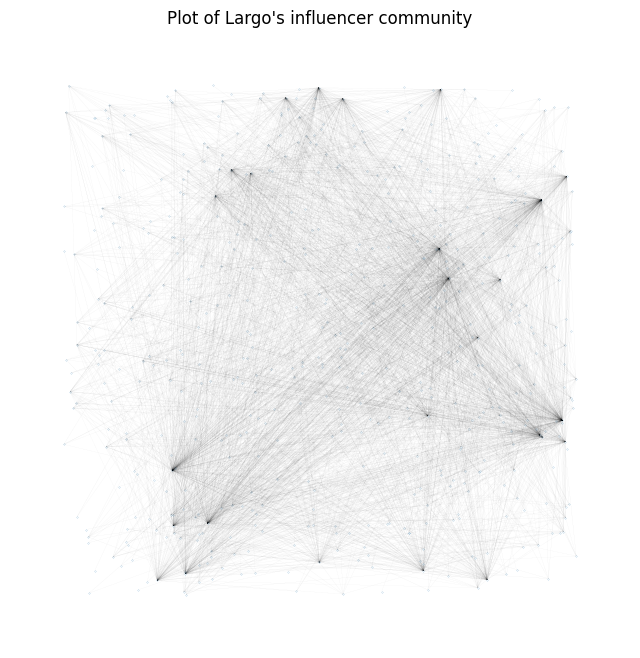

In [ ]:
plt.figure(figsize=(8,8))
plt.title("Plot of Largo's influencer community")
#https://stackoverflow.com/questions/21978487/improving-python-networkx-graph-layout
nx.draw_random(influencers_sub_graph,node_size=0.01, width=0.01)

In [ ]:
#can we identify distinct communities within the influencer community?
#from the above graph it certainly looks like we can!
import community.community_louvain as community  # <-- important!
parts = community.best_partition(influencers_sub_graph)
values = [parts.get(node) for node in influencers_sub_graph.nodes()]

print(len(set(values))," Communities have been identified")

7  Communities have been identified


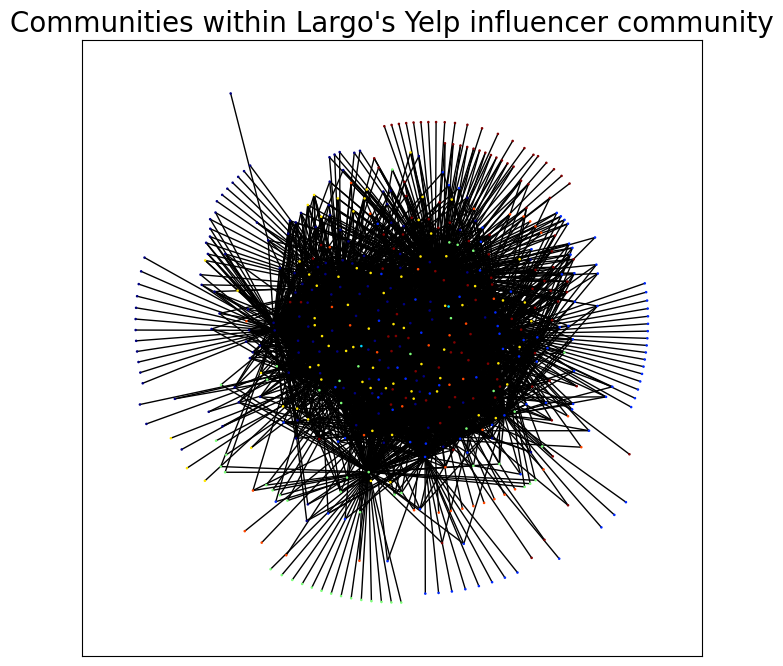

In [ ]:
#now let's look at those 7 communities (each community is represented by a distinct color)
#pos = nx.spring_layout(influencers_sub_graph)
pos2=nx.kamada_kawai_layout(influencers_sub_graph)

plt.figure(figsize=(8,8))
plt.axes=False
plt.title("Communities within Largo's Yelp influencer community",fontsize=20)
nx.draw_networkx(influencers_sub_graph, pos = pos2,cmap = plt.get_cmap("jet"), node_color = values, node_size = 0.7, with_labels = False)